In this notebook we simulate future stock prices, risk-free rates, 3 year bonds and sharpe ratios from 31 october 2014 to 31 october 2033. We assume that the voatility follows stockastic process (Heston Model). We assume that other 

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 1. Market Simulation Code

$
\begin{cases}
r_{t+dt} = r_t + \kappa_r (\bar{lt_r} - r_t) dt + \sigma_r \sqrt{dt} Z_t^r\\
SR_{t+dt} = SR_t + \kappa_sr (\bar{lt_sr} - SR_t) dt + \sigma_SR \sqrt{dt} Z_t^SR\\
V_{t+dt} = V_t + \kappa_v (lt_V - V_t) dt + \sigma_V \sqrt{V_t} \sqrt{dt} Z_t^V\\
S_{t+dt} = S_t \times \exp \left( \left( r + \bar{\lambda_0} \sigma_t - \frac{1}{2} \sigma_t^2 \right) dt + \sigma_t \sqrt{dt} Z_t^S \right) \\
\end{cases}
$

In [17]:
import numpy as np
import pandas as pd

class MarketSimulator:
    def __init__(
        self, 
        # Basic notations
        T,        # Total time in years for the simulation
        N,        # Number of discrete time steps; e.g., 252 for "trading days" in a year
        M,        # Number of simulation paths (scenarios)
        seed=123, # Random seed for reproducibility
        
        # Initial conditions
        S0=1,         # Initial stock price
        r0=0.15 / 100,      # Initial short rate
        sr0=0.4,      # Initial Sharpe ratio
        v0=(0.2138)**2, # Initial variance (square of initial volatility)
        
        # Short-rate (Vasicek) model parameters
        lt_r=0.0306,    # Long-term mean (b in Vasicek) to which r reverts
        kappa_r=0.13,   # Mean-reversion speed for short rate
        sigma_r=0.98/100, # Volatility (std dev) of short rate’s diffusion
        lambda_r=-53/100/100, # Market price of risk associated with interest rate movements
        
        # Sharpe-ratio (Ornstein–Uhlenbeck type) model parameters
        lt_sr=0.4,     # Long-term mean Sharpe ratio
        kappa_sr=0.35, # Mean-reversion speed for Sharpe ratio
        sigma_sr=0.2322, # Volatility (std dev) of Sharpe ratio process
        
        # Variance (Heston-like) model parameters
        kappa_variance=5.07,  # Mean-reversion speed of variance process
        lt_variance=(0.2138)**2, # Long-term mean of variance process
        sigma_variance=0.48,  # Vol of vol (volatility of variance process)
        
        # Correlations for covariance matrix
        # (Z is 4D, representing Brownian increments for: stock, variance, Sharpe ratio, short rate)
        rho_stock_volatility=-0.767, # Corr( dW_stock, dW_vol ) 
        rho_stock_sr=-0.2,           # Corr( dW_stock, dW_sr   )
        rho_volatility_sr=+0.767,    # Corr( dW_vol,   dW_sr   )

        # Constant maturity bond index set up
        tau = 3, # Time to maturity in years of the bond index (default = 3 years)
        B0 = 1   # Initial price of the bond index
    ):
        """Initializes the Market Simulator with all parameters."""
        
        # Simulation settings
        self.T, self.N, self.M, self.seed = T, N, M, seed  # Total time horizon, number of time steps, number of paths, random seed
        
        # Initial values
        self.S0, self.r0, self.sr0, self.v0 = S0, r0, sr0, v0  # Initial values for stock price, short rate, Sharpe ratio, and variance
        
        # Short-rate (Vasicek) model parameters
        self.lt_r, self.kappa_r, self.sigma_r, self.lambda_r = lt_r, kappa_r, sigma_r, lambda_r  # Long-term mean, mean reversion speed, volatility, and market price of risk
        
        # Sharpe-ratio (Ornstein–Uhlenbeck type) model parameters
        self.lt_sr, self.kappa_sr, self.sigma_sr = lt_sr, kappa_sr, sigma_sr  # Long-term mean, mean reversion speed, and volatility of Sharpe ratio
        
        # Variance (Heston-like) model parameters
        self.kappa_variance, self.lt_variance, self.sigma_variance = kappa_variance, lt_variance, sigma_variance  # Mean reversion speed, long-term mean, and vol of vol
        
        # Correlations for covariance matrix
        self.rho_stock_volatility, self.rho_stock_sr, self.rho_volatility_sr = rho_stock_volatility, rho_stock_sr, rho_volatility_sr  # Correlation among Brownian motions
        
        # Time step size in years
        self.dt = T / N  # Compute dt from total time and number of steps
        
        # Set up risk-neutral under Q measure long-term short rate
        self.lt_r_q = lt_r + sigma_r * lambda_r / kappa_r  # Adjusted long-term mean for risk-neutral valuation

        # generate the market paths
        self.generate_paths()

        # set up constant maturity bond index
        self.tau = tau 
        self.B0 = B0
        
        zero_coupon_bond_prices_for_constant_maturity_bond_index = self.vasicek_zcb_price(self.r_p, self.tau)
        
        # find price of constant maturity bond index
        self.B_p = self.deduce_constant_maturity_bond_index(zero_coupon_bond_prices_for_constant_maturity_bond_index)

        # set the retirement bond price to nothing. To initialize it run "self.calculate_perfect_retirement_bond(client)"
        # where client comes from 'RetirementClient' class
        self.retirement_bond_p = pd.DataFrame(index = self.r_p.index)
        
    def generate_paths(self):
        """Simulates multiple paths of stock price, variance, Sharpe ratio, and short rate."""
        np.random.seed(self.seed)  # Set random seed for reproducibility
        
        # Mean (0-vector) and covariance matrix for Brownian increments
        mu = np.array([0, 0, 0, 0])  # Zero mean for Brownian motion
        cov = np.array([
            [1, self.rho_stock_volatility, self.rho_stock_sr, 0],  # Correlation matrix for Brownian motions
            [self.rho_stock_volatility, 1, self.rho_volatility_sr, 0],
            [self.rho_stock_sr, self.rho_volatility_sr, 1, 0],
            [0, 0, 0, 1]  # Independent short rate process
        ])
        
        # Initialize paths
        S = np.full((self.N+1, self.M), self.S0)  # Stock price paths
        v = np.full((self.N+1, self.M), self.v0)  # Variance paths
        sr = np.full((self.N+1, self.M), self.sr0)  # Sharpe ratio paths
        r = np.full((self.N+1, self.M), self.r0)  # Short rate paths
        
        # Generate correlated Brownian increments
        Z = np.random.multivariate_normal(mu, cov, size=(self.N, self.M))
        
        # Main simulation loop
        for i in range(1, self.N+1):
            # Stock price evolution using exponential Euler scheme
            S[i] = S[i-1] * np.exp((r[i-1] + sr[i-1] * np.sqrt(v[i-1]) - 0.5 * v[i-1]) * self.dt + np.sqrt(v[i-1] * self.dt) * Z[i-1,:,0])
            
            # Variance follows a mean-reverting Heston-like process
            v[i] = np.maximum(v[i-1] + self.kappa_variance * (self.lt_variance - v[i-1]) * self.dt + self.sigma_variance * np.sqrt(v[i-1]) * np.sqrt(self.dt) * Z[i-1,:,1], 0)
            
            # Sharpe ratio follows an Ornstein–Uhlenbeck process
            sr[i] = sr[i-1] + self.kappa_sr * (self.lt_sr - sr[i-1]) * self.dt + self.sigma_sr * np.sqrt(self.dt) * Z[i-1,:,2]
            
            # Short rate follows a Vasicek model under the risk-neutral measure
            r[i] = r[i-1] + self.kappa_r * (self.lt_r_q - r[i-1]) * self.dt + self.sigma_r * np.sqrt(self.dt) * Z[i-1,:,3]
        
        # Convert outputs to DataFrame with time index

        self.S_p = pd.DataFrame(S, index=np.linspace(0, self.T, len(S)))
        self.v_p = pd.DataFrame(v, index=np.linspace(0, self.T, len(S)))
        self.sr_p = pd.DataFrame(sr, index=np.linspace(0, self.T, len(S)))
        self.r_p = pd.DataFrame(r, index=np.linspace(0, self.T, len(S)))

    def vasicek_zcb_price(self, r_t, tau):
        """
        Computes the price P(t, t+tau) of a zero-coupon bond under the Vasicek model.
    
        Parameters:
        - r_t: Short rate at time t
        - tau: Time to maturity in years (default = 3 years)
    
        Returns:
        - Price of the zero-coupon bond P(t, t+tau)
        """
        # Compute B(t, T) factor in Vasicek model
        B = (1.0 - np.exp(-self.kappa_r * tau)) / self.kappa_r
    
        # Compute A(t, T) factor in Vasicek model
        A_term1 = (self.lt_r_q - (self.sigma_r**2) / (2.0 * self.kappa_r**2)) * (B - tau)
        A_term2 = (self.sigma_r**2) / (4.0 * self.kappa_r) * B**2
        A = np.exp(A_term1 - A_term2)  # Fixed: Applied exponentiation as per formula
    
        # Compute bond price using Vasicek formula
        return A * np.exp(-B * r_t)

    def vasicek_zcb_yield(self, tau):
        """
        Computes the price P(t, t+tau) yeild curve of a zero-coupon bond under the Vasicek model.
    
        Parameters:
        - r_t: Short rate at time t
        - tau: Time to maturity in years (default = 3 years)
    
        Returns:
        - Yield curve of bond P(t, t+tau)
        """
        # Compute B(t, T) factor in Vasicek model
        B = (1.0 - np.exp(-self.kappa_r * self.tau)) / self.kappa_r
    
        # Compute A(t, T) factor in Vasicek model
        A_term1 = (self.lt_r_q - (self.sigma_r**2) / (2.0 * self.kappa_r**2)) * (B - tau)
        A_term2 = (self.sigma_r**2) / (4.0 * self.kappa_r) * B**2
        A = np.exp(A_term1 - A_term2)  # Fixed: Applied exponentiation as per formula
    
        # Compute bond price using Vasicek formula
        return -np.log(A * np.exp(-B * self.r_p))/tau
    
    def deduce_constant_maturity_bond_index(self, zero_coupon_prices):
        """
        Computes a constant maturity bond index based on zero-coupon bond prices and short-term interest rates.
    
        Parameters:
        zero_coupon_prices (DataFrame): Zero-coupon bond prices for different maturities over time.
        r_p (Series or DataFrame): Short-term interest rates (or bond yields).
        dt (float): Time step size.
        initial_investment (float, optional): Initial investment amount. Default is 100.
    
        Returns:
        DataFrame: Computed bond index values.
        """
        
        # Compute the return from changes in zero-coupon bond prices
        return_from_change_in_bond_price = zero_coupon_prices.pct_change().fillna(0)
    
        # Include the dt factor explicitly
        return_from_coupons = self.r_p * self.dt  # Keeps dt in formula
    
        # Compute total return index
        index_return = return_from_coupons + return_from_change_in_bond_price
    
        # Compute bond index, scaling by initial investment
        bond_index = self.B0 * (index_return+1).cumprod()
    
        return bond_index

    

    def calculate_perfect_retirement_bond(self, 
                                          client):
        """
        This function calculates price of the perfect retirement bond 
        given the market conditions.

        Essentially it calculates zc bond matrix for each scenario and 
        finds present value of the cash flows. these PVs are the perfect
        discounted values of CFs = perfect retirement bond. The least 
        risky asset that allows to reach the goal with certain probability

        Parameters:
        client (Class): A client initialized through the class "RetirementClient"
                        They should have views on their CFs + periodociy
                        periodicity is used for initializing cash flows more often
                        ### IMPORTANT ### Higher periodicity makes this code slower,

        Returns:
        df_pv_retirement_bonds (DataFrame): retirement bond price
        
        """

        retirement_bond_p = pd.DataFrame(index = self.r_p.index)
                              
        for simulation_number in tqdm(self.r_p.columns):
            
            # Step 1. Initialization
            # initialize CFs. It is crucial to do in in-cycle, because this df will be changed
            CFs = client.cash_flows_df
            # simulated short term rates for 1 scenario for the market
            r_p_short_term = self.r_p.loc[:,simulation_number]
            # this periodicity will be used to shift CFs (to calculate present values)
            periodicity_of_CF_shift = 1 / client.periodicity
        
            # Step 2. ZC matrix
            # calculate matrix of zc bond prices for all maturities and all effective dates
            # it is calculated using simulated short term rates and vasicek zc bond price
            zc_bond_prices_dict = {}
            for period in CFs.index:
                zc_bond_prices_dict[period] = self.vasicek_zcb_price(r_p_short_term, tau=period)
            zc_bond_prices = pd.DataFrame.from_dict(zc_bond_prices_dict, orient='index').T
        
        
            # Step 3. Find all PVs of the client cash flows
            # The task is to gather PVs of the future cash flows at each period of time
            # This is a price of perfect GHP, maurity bond
            
            PVs = []
            current_period = 0
            
            # to find these PVs I would need to iterate through each effective date as if I was there
            for period in zc_bond_prices.index:
            
                # for each of the dates I find the PV of those future CFs using the constructed table
                discounted_CFs = CFs['Pure_Cash_Flow'] * zc_bond_prices.loc[period,:]
                PVs.append(np.sum(discounted_CFs))
            
                # every period there happens a shift in CFs: they become closer to the current date
                # Therefore, they should shift 1 period
                if current_period != period // periodicity_of_CF_shift:
                    
                    # update current period
                    current_period = period // periodicity_of_CF_shift
                    
                    # the year has changed => CFs should shift
                    CFs = CFs.shift(-1).fillna(0)
                    
            # Step 4. Save the results
            retirement_bond_p.loc[:,simulation_number] = PVs
            self.retirement_bond_p = retirement_bond_p
    
    def plot_market_simulation(self):
        """
        This function plots the stock price, intereset rate,
        Stock volatility and stock sharpe ratio
        """
        fig, axes = plt.subplots(3, 2, figsize=(12, 10))

        # --- (1) Heston Model log of Asset Prices ---
        axes[0, 0].plot(self.S_p.index, np.log(self.S_p), alpha=0.6)
        axes[0, 0].set_title("Heston Model Log of Asset Prices")
        axes[0, 0].set_xlabel("Time")
        axes[0, 0].set_ylabel("Log-Price Level")
        axes[0, 0].grid(True)
        
        # --- (2) Heston Model Variance Process ---
        axes[1, 0].plot(self.v_p.index, self.v_p, alpha=0.6)
        axes[1, 0].set_title("Heston Model Variance Process")
        axes[1, 0].set_xlabel("Time")
        axes[1, 0].set_ylabel("Variance")
        axes[1, 0].grid(True)
        
        # --- (3) Sharpe Ratio Process ---
        axes[0, 1].plot(self.sr_p.index, self.sr_p, alpha=0.6)
        axes[0, 1].set_title("Sharpe Ratio Process")
        axes[0, 1].set_xlabel("Time")
        axes[0, 1].set_ylabel("Sharpe Ratio")
        axes[0, 1].grid(True)
        
        # --- (4) Vasicek Process (Interest Rate) ---
        axes[1, 1].plot(self.r_p.index, self.r_p, alpha=0.6)
        axes[1, 1].set_title("Vasicek Process short term rate")
        axes[1, 1].set_xlabel("Time")
        axes[1, 1].set_ylabel("Interest Rate")
        axes[1, 1].grid(True)
        
        # --- (5) Constant Maturity Bond Index ---
        axes[2, 0].plot(self.B_p.index, self.B_p, alpha=0.6)
        axes[2, 0].set_title(f"Constant Maturity {self.tau} years Bond Index")
        axes[2, 0].set_xlabel("Time")
        axes[2, 0].set_ylabel("Price")
        axes[2, 0].grid(True)

        # --- (6) Retirement Bond ---
        axes[2, 1].plot(self.retirement_bond_p.index, self.retirement_bond_p, alpha=0.6)
        axes[2, 1].set_title(f"Perfect Retirement Bond Index")
        axes[2, 1].set_xlabel("Time")
        axes[2, 1].set_ylabel("Price")
        axes[2, 1].grid(True)
                
        plt.tight_layout()

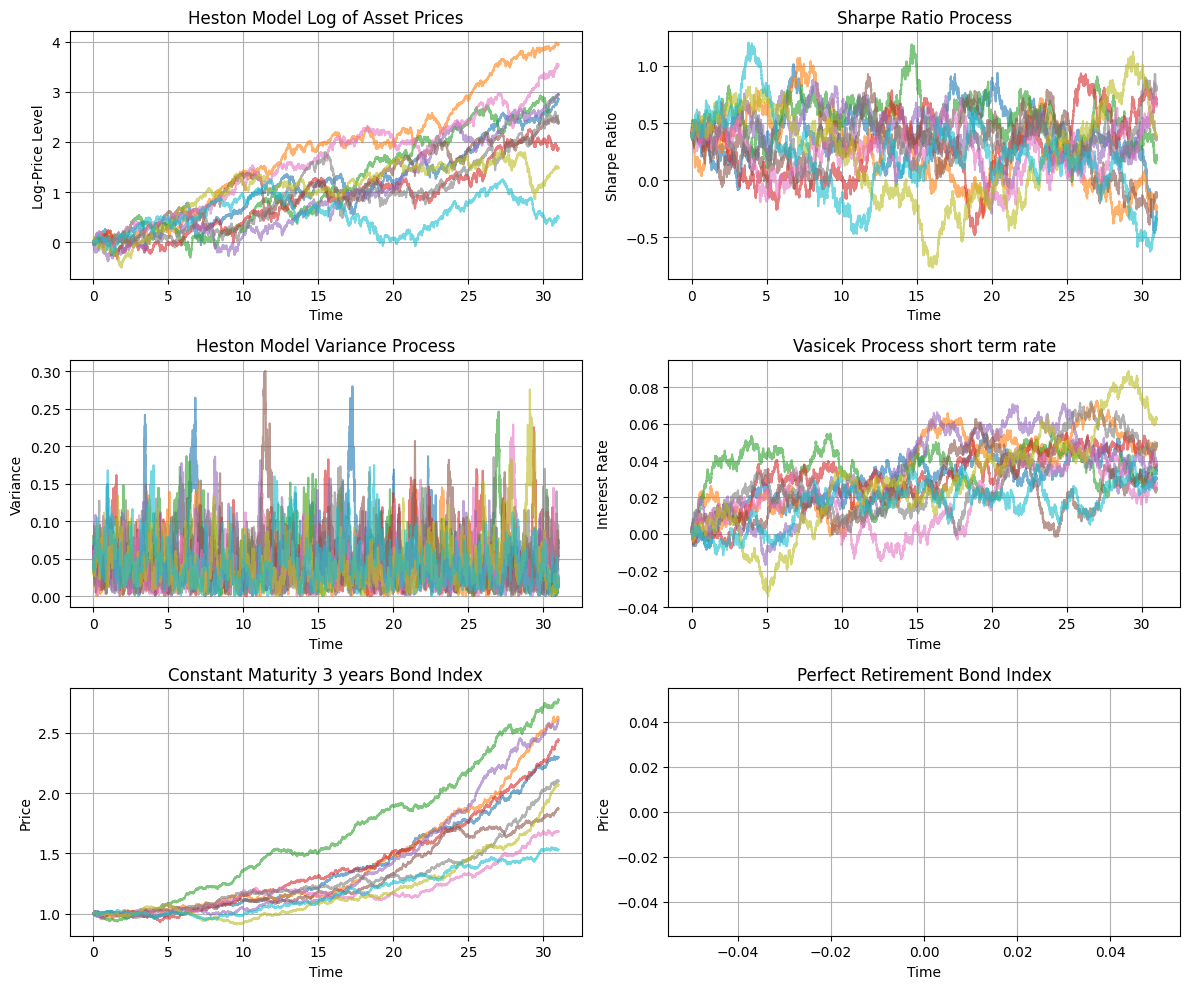

In [18]:
# Parameters
S0 = 1.0              # asset price
T = 31                  # time in years
N = 252*T              # number of time steps in simulation
M = 10                  # number of simulated paths
seed = 123              # simulation seed

simulated_market = MarketSimulator(T,N,M,seed, S0)
simulated_market.plot_market_simulation()

We can try to simulate 11 year bond, 12 year bonds, etc. to match our future essential cash flows. Then check the present value distribution that might be needed.

## Initialize client

In [19]:
class RetirementClient:
    def __init__(self,
                 name,
                 accumulation_years=10,
                 accumulation_cash_flow=0,
                 decumulation_years=20,
                 decumulation_cash_flow=50000,
                 periodicity = 12
                ):
        """
        Initializes a RetirementClient with given parameters.

        :param name: Name of the client
        :param accumulation_years: Number of years the client is saving money
        :param accumulation_cash_flow: Annual contribution during accumulation phase (per trading day)
        :param decumulation_years: Number of years the client is withdrawing money
        :param decumulation_cash_flow: Annual withdrawal amount during decumulation phase (only at start of each year)
        :param periodicity: Number of periods in a year
        """
        self.name = name
        self.accumulation_years = accumulation_years
        self.accumulation_cash_flow = accumulation_cash_flow
        self.decumulation_years = decumulation_years
        self.decumulation_cash_flow = decumulation_cash_flow
        self.periodicity = periodicity
        self.generate_cash_flows()
        
    def generate_cash_flows(self):
        """
        Generates a DataFrame of cash flows at a daily trading frequency (1/252 increments).
        
        - Accumulation period (X years, X*periodicity periods): Cash flow appears at period 1 of each year.
        - Decumulation period (Y years, Y*periodicity periodss): Cash flow appears at period 1 of each year.

        :return: pandas DataFrame with the following columns:
            - 'Period': The time index in trading days (1/252 increments)
            - 'Year': The corresponding year number
            - 'Pure_Cash_Flow': The nominal cash flows (without inflation adjustments)
        """
        total_periods = (self.accumulation_years + self.decumulation_years) * self.periodicity  # Total periods
        periods = np.arange(1, total_periods + 1)  # period index
        
        # Initialize cash flow array with zeros
        cash_flows = np.zeros(total_periods)
        
        # Set cash flow at the beginning of each year during decumulation
        for year in range(self.accumulation_years, self.accumulation_years + self.decumulation_years):
            cash_flows[year * self.periodicity] = self.decumulation_cash_flow
        
        # Convert to DataFrame
        self.cash_flows_df = pd.DataFrame({
            'Period': periods / self.periodicity, 
            'Year': (periods // self.periodicity) + 1,
            'Pure_Cash_Flow': cash_flows
            })
        self.cash_flows_df.index = self.cash_flows_df.Period

    def plot_cash_flows(self):
        """
        Plots the cash flow over the trading years.
        """
        plt.figure(figsize=(12, 5))
        plt.bar(self.cash_flows_df['Period'], self.cash_flows_df['Pure_Cash_Flow'], 
                color='darkblue', edgecolor='white', width=0.1)
        plt.xlabel("Time (Trading Years)")
        plt.ylabel("Cash Flow")
        plt.title(f"Cash Flow Projection for {self.name}")
        plt.axhline(0, color='black', linewidth=1)
        plt.show()

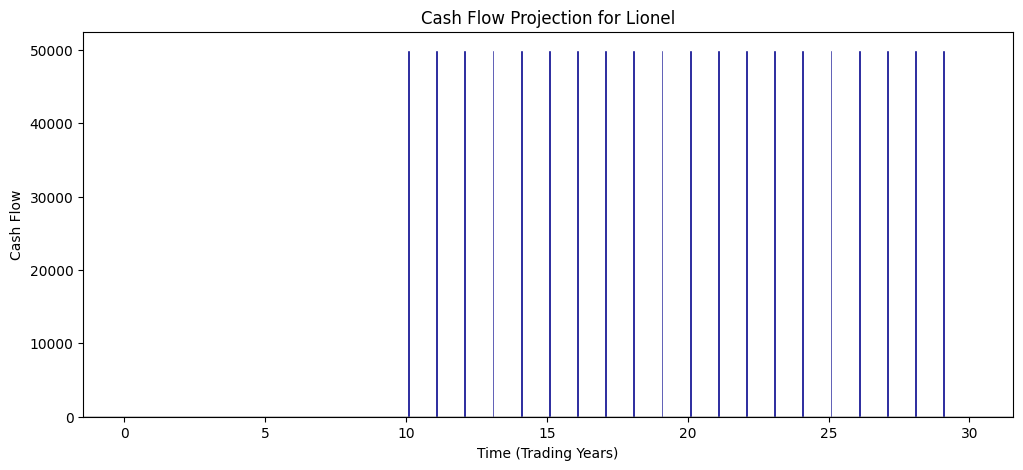

In [20]:
client = RetirementClient("Lionel",
                           accumulation_years=10,
                           accumulation_cash_flow=0,
                           decumulation_years=20,
                           decumulation_cash_flow=50000,
                           periodicity = 12)

client.plot_cash_flows()

## Retirement Bond

In [21]:
simulated_market.calculate_perfect_retirement_bond(client)

100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.28s/it]


Plot the market and the retirement bond index

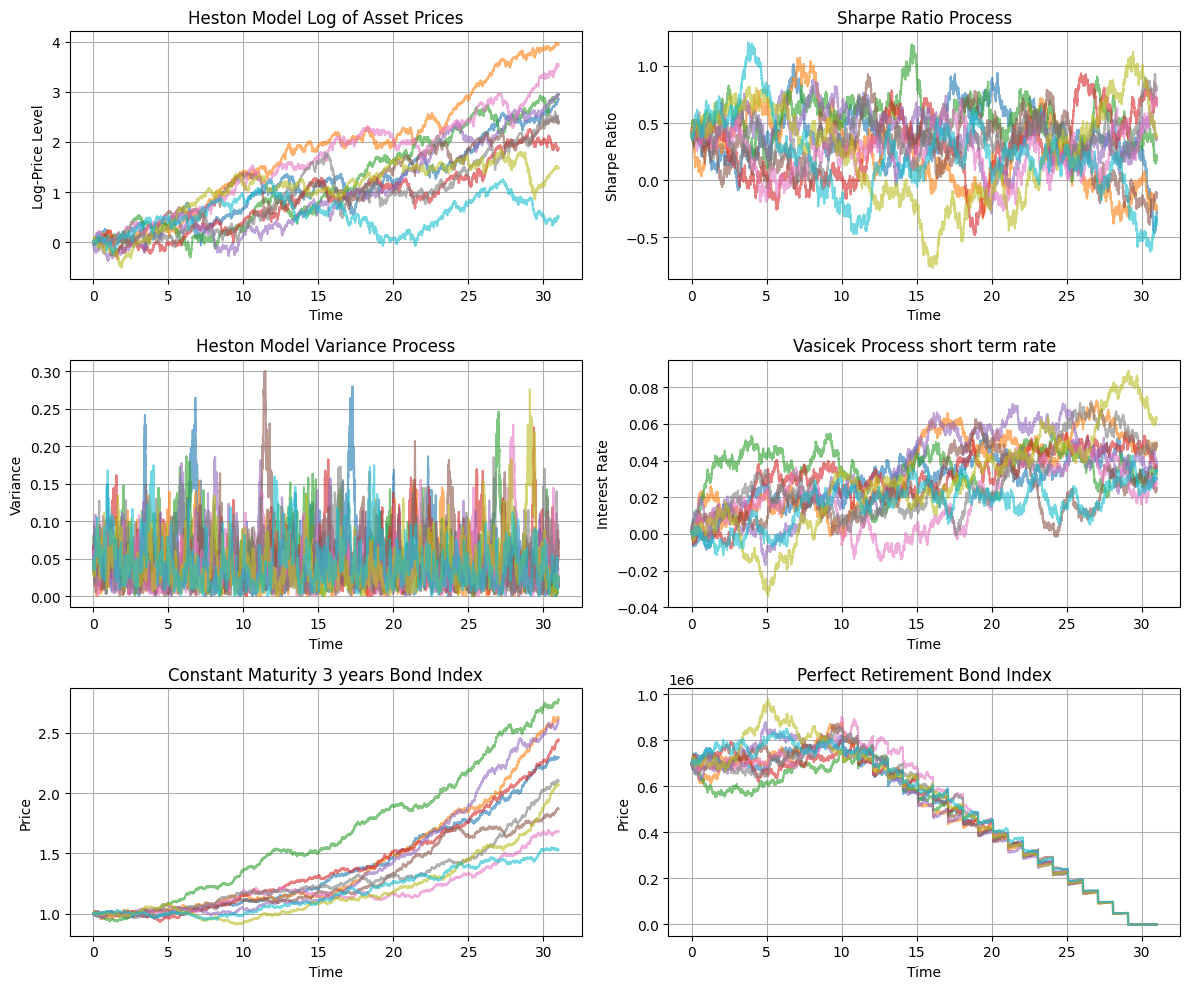

In [22]:
simulated_market.plot_market_simulation()

In [6]:
###
# imput:
# 1) client
# 2) self


In [7]:
df_pv_retirement_bonds = pd.DataFrame(index = simulated_market.r_p.index)

for simulation_number in tqdm(simulated_market.r_p.columns):
    
    # Step 1. Initialization
    # initialize CFs. It is crucial to do in in-cycle, because this df will be changed
    CFs = client.cash_flows_df
    # simulated short term rates for 1 scenario for the market
    r_p_short_term = simulated_market.r_p.loc[:,simulation_number]
    # this periodicity will be used to shift CFs (to calculate present values)
    periodicity_of_CF_shift = 1 / client.periodicity

    # Step 2. ZC matrix
    # calculate matrix of zc bond prices for all maturities and all effective dates
    # it is calculated using simulated short term rates and vasicek zc bond price
    zc_bond_prices_dict = {}
    for period in CFs.index:
        zc_bond_prices_dict[period] = simulated_market.vasicek_zcb_price(r_p_short_term, tau=period)
    zc_bond_prices = pd.DataFrame.from_dict(zc_bond_prices_dict, orient='index').T


    # Step 3. Find all PVs of the client cash flows
    # The task is to gather PVs of the future cash flows at each period of time
    # This is a price of perfect GHP, maurity bond
    
    PVs = []
    current_period = 0
    
    # to find these PVs I would need to iterate through each effective date as if I was there
    for period in zc_bond_prices.index:
    
        # for each of the dates I find the PV of those future CFs using the constructed table
        discounted_CFs = CFs['Pure_Cash_Flow'] * zc_bond_prices.loc[period,:]
        PVs.append(np.sum(discounted_CFs))
    
        # every period there happens a shift in CFs: they become closer to the current date
        # Therefore, they should shift 1 period
        if current_period != period // periodicity_of_CF_shift:
            
            # update current period
            current_period = period // periodicity_of_CF_shift
            
            # the year has changed => CFs should shift
            CFs = CFs.shift(-1).fillna(0)
    # Step 4. Save the results
    df_pv_retirement_bonds.loc[:,simulation_number] = PVs

100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]


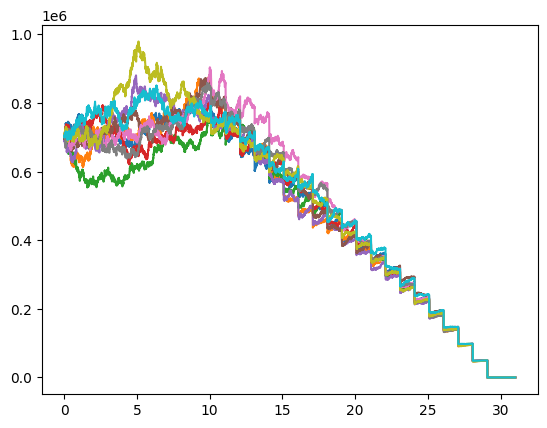

In [9]:
plt.plot(df_pv_retirement_bonds);

In [400]:
PVs[:252*10+23][-1]

49958.637770060115

In [202]:
CFs['Pure_Cash_Flow']

Year
1     50000.0
2         0.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         0.0
9         0.0
10        0.0
11        0.0
12        0.0
13        0.0
14        0.0
15        0.0
16        0.0
17        0.0
18        0.0
19        0.0
20        0.0
21        0.0
22        0.0
23        0.0
24        0.0
25        0.0
26        0.0
27        0.0
28        0.0
29        0.0
30        0.0
Name: Pure_Cash_Flow, dtype: float64

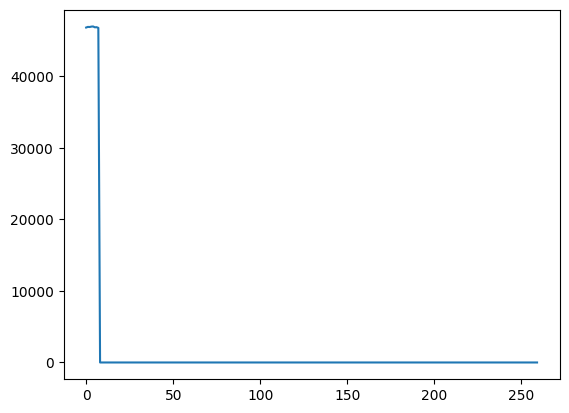

In [228]:
plt.plot(PVs[-260:])

In [154]:
day2 = zc_bond_prices.index[1]

In [155]:
CFs['Pure_Cash_Flow'].index - day2

Index([ 0.996031746031746,  1.996031746031746,  2.996031746031746,
        3.996031746031746,  4.996031746031746,  5.996031746031746,
        6.996031746031746,  7.996031746031746,  8.996031746031745,
        9.996031746031745, 10.996031746031745, 11.996031746031745,
       12.996031746031745, 13.996031746031745, 14.996031746031745,
       15.996031746031745, 16.996031746031747, 17.996031746031747,
       18.996031746031747, 19.996031746031747, 20.996031746031747,
       21.996031746031747, 22.996031746031747, 23.996031746031747,
       24.996031746031747, 25.996031746031747, 26.996031746031747,
       27.996031746031747, 28.996031746031747, 29.996031746031747],
      dtype='float64', name='Year')

In [153]:
day2

Index([                 0.0, 0.003968253968253968, 0.007936507936507936,
       0.011904761904761904, 0.015873015873015872,  0.01984126984126984,
       0.023809523809523808, 0.027777777777777776, 0.031746031746031744,
        0.03571428571428571,
       ...
          9.964285714285714,    9.968253968253968,    9.972222222222221,
          9.976190476190476,     9.98015873015873,    9.984126984126984,
          9.988095238095237,    9.992063492063492,    9.996031746031745,
                       10.0],
      dtype='float64', length=2521)

In [81]:
q = simulated_market.vasicek_zcb_yield(tau = 1)
w = simulated_market.vasicek_zcb_yield(tau = 2)
e = simulated_market.vasicek_zcb_yield(tau = 3)
r = simulated_market.vasicek_zcb_yield(tau = 4)
t = simulated_market.vasicek_zcb_yield(tau = 5)
y = simulated_market.vasicek_zcb_yield(tau = 6)

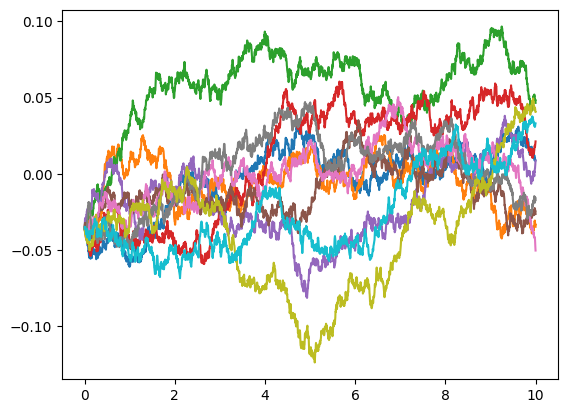

In [82]:
plt.plot(q);

In [83]:
s = 0

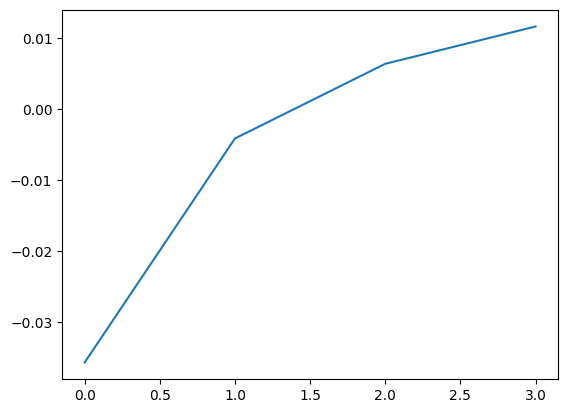

In [84]:
plt.plot([q.iloc[0,s], w.iloc[0,s], e.iloc[0,s],r.iloc[0,s]]);

In [5]:
# both give wrong result
def deduce_yield(zc_price, tau):
    return -np.log(zc_price) / tau

# both give wrong result
#def deduce_yield(zc_price, tau):
#    return ((1/zc_price)** (1/ tau)) -1

In [6]:
st_rate = 0.02#r_p[0][0]
zc_prices = []
zc_yields = []

taus = np.arange(1,31,1)

for tau in taus:
    zc_price = vasicek_zcb_price(st_rate, tau=tau, kappa_r=0.13, lt_r=0.0306, sigma_r=0.015)
    zc_prices.append(zc_price)

zc_yeilds = deduce_yield(zc_prices, taus)

NameError: name 'vasicek_zcb_price' is not defined

In [ ]:
plt.plot(deduce_yield(np.array(zc_prices),np.arange(1,31,1)))